# **ASSIGNMENT 3**

**Task**: forecast the real price of gasoline for the US.

**Dataset**: gasoline.xlsx contains two monthly time series. The nominal price of gasoline and the CPI. 


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from fredapi import Fred

pd.set_option('colheader_justify', 'center')
pd.set_option("display.precision", 2)

In [111]:
fred_key = '17193bb5d3d0af2508e249e344961fcf'
fred = Fred(api_key=fred_key)

In [112]:
def get_fred_data(code):
    return fred.get_series(code, frequency = 'm') # m = monthly

fred_codes = {'CPI' : 'CPIAUCSL',
              'Nominal_Price' : 'GASREGW'}

gasoline = pd.DataFrame()

for var in fred_codes.keys():
    gasoline[var] = get_fred_data(fred_codes[var])

In [113]:
gasoline['Time'] = pd.to_datetime(gasoline.index)
gasoline = gasoline.query("Time >= '1990-11-01'")
gasoline.head()

,CPI,Nominal_Price,Time
1990-11-01,133.7,1.32,1990-11-01
1990-12-01,134.2,1.34,1990-12-01
1991-01-01,134.7,1.18,1991-01-01
1991-02-01,134.8,1.09,1991-02-01
1991-03-01,134.8,1.04,1991-03-01


# 1) Create the real price of gasoline

In [114]:
gasoline['Real_Price'] = (gasoline['Nominal_Price']/gasoline['CPI'])*100
gasoline.head(5)

,CPI,Nominal_Price,Time,Real_Price
1990-11-01,133.7,1.32,1990-11-01,0.99
1990-12-01,134.2,1.34,1990-12-01,1.00
1991-01-01,134.7,1.18,1991-01-01,0.88
1991-02-01,134.8,1.09,1991-02-01,0.81
1991-03-01,134.8,1.04,1991-03-01,0.77


## 2)  Plot real and nominal prices over time.

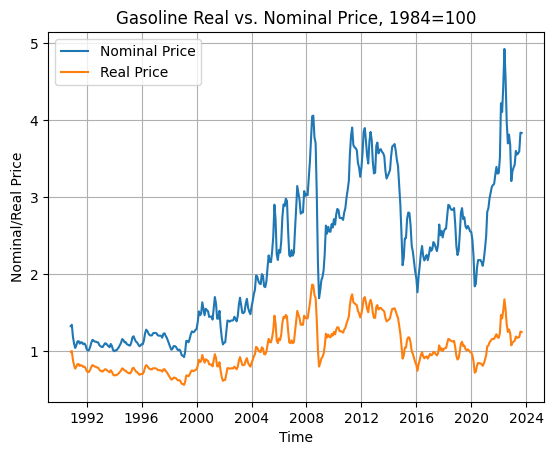

In [115]:
plt.plot(gasoline['Time'], gasoline['Nominal_Price'], label = 'Nominal Price')
plt.plot(gasoline['Time'], gasoline['Real_Price'], label='Real Price')

plt.title('Gasoline Real vs. Nominal Price, 1984=100')
plt.xlabel('Time')
plt.ylabel('Nominal/Real Price')
plt.legend()
plt.grid()

Alternatively, plot them separately. Be aware of the different y-axis!

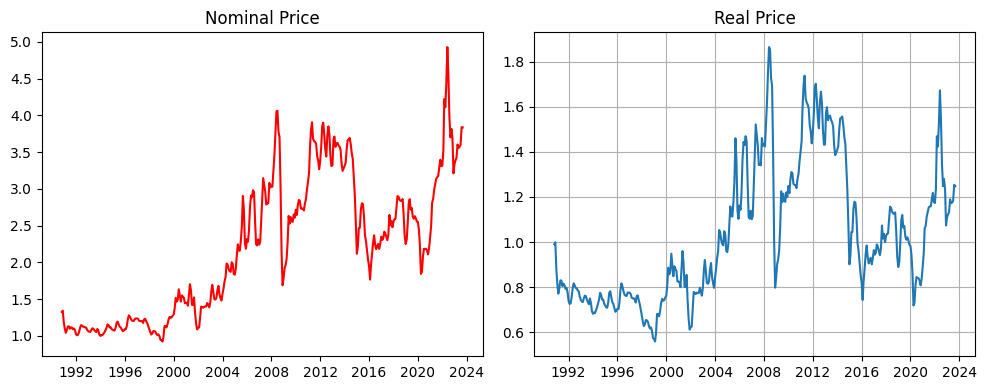

In [116]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
ax[0].plot(gasoline['Time'], gasoline['Nominal_Price'], color='red')
ax[0].set_title('Nominal Price')
plt.grid()

ax[1].plot(gasoline['Time'], gasoline['Real_Price'])
ax[1].set_title('Real Price')

plt.tight_layout()
plt.show()

## 3) Consider the sample from obs 1 to Dec 2014. Plot the sample ACF of $y_{t}$ and $\Delta{y_t} = y_{t} - y_{t-1}$.

Now the $y_{t}$ has to be intended as _log_


In [117]:
# filter the data as requested
train = gasoline.query(" Time <= '2014-12-01' ")
test = gasoline.query(" Time > '2014-12-01' ")

# convert the data from float to numeric...
train['Real_Price'] = pd.to_numeric(train['Real_Price'], errors='coerce')

# ... otherwise we couldn't apply the .log() function
train['Log_Real_Price'] = np.log(train['Real_Price'])

# create the column delta for the first difference of the log price
train['Delta_Log'] = (train['Log_Real_Price']-train['Log_Real_Price'].shift(1))

# fill the first value with 0, otherwise the next code chunk won't produce an accurate ACF
train['Delta_Log'].fillna(0, inplace=True)

train.tail()

C:\Users\giord\AppData\Local\Temp\ipykernel_2628\140007827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Real_Price'] = pd.to_numeric(train['Real_Price'], errors='coerce')
C:\Users\giord\AppData\Local\Temp\ipykernel_2628\140007827.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Log_Real_Price'] = np.log(train['Real_Price'])
C:\Users\giord\AppData\Local\Temp\ipykernel_2628\140007827.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,CPI,Nominal_Price,Time,Real_Price,Log_Real_Price,Delta_Log
2014-08-01,237.46,3.49,2014-08-01,1.47,0.38,-0.03
2014-09-01,237.48,3.41,2014-09-01,1.43,0.36,-0.02
2014-10-01,237.43,3.17,2014-10-01,1.34,0.29,-0.07
2014-11-01,236.98,2.91,2014-11-01,1.23,0.21,-0.08
2014-12-01,236.25,2.54,2014-12-01,1.08,0.07,-0.13


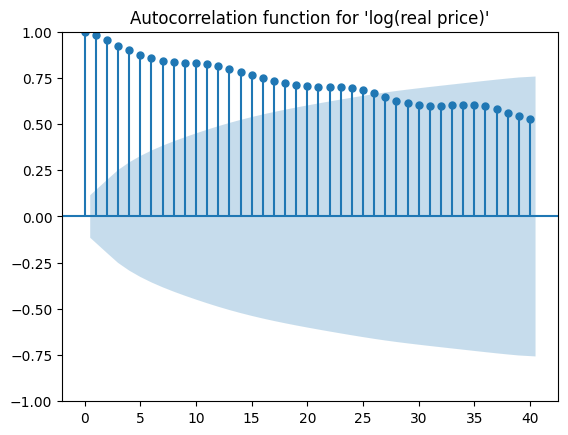

In [118]:
plot_acf(train['Log_Real_Price'], 
         lags=40,
         title="Autocorrelation function for 'log(real price)'");

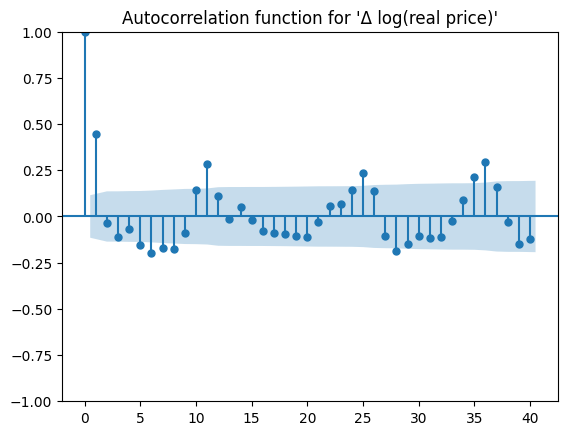

In [119]:
plot_acf(train['Delta_Log'], 
         lags=40, 
         title="Autocorrelation function for 'Δ log(real price)'");

## 4) Using the same sample above fit two AR(1) models: the first for $y_{t}$ and the second for Δ$y_{t}$. Report in both cases the coefficient associated with the lagged dependent variable.


In [120]:
# If the pvalue is above a critical size, then we cannot reject the null hypothesis that there is a unit root.
stationarity_test = adfuller(train['Log_Real_Price'], autolag='AIC')
stationarity_test

(-1.1021096314964258,
 0.7142298756294339,
 15,
 274,
 {'1%': -3.4544435065994437,
  '5%': -2.8721468827772774,
  '10%': -2.572422013959188},
 -900.0168558851688)

Since the ADF statistic, -1.10, is > than t-values at (1%,5%,10%), the null hypothesis **CANNOT** be rejected, where the null hypothesis is that there exists a unit root. If there exists a unit root, then the process is **NON**-stationary.


In my case, the ADF statistic is greater than the critical values. This suggests that the null hypothesis of a unit root is not rejected, indicating that the time series might indeed be NON-stationary (= it has relation with time).

Moreover, the p-value (0.71) exceed the significance level of 0.01, 0.05, 0.1.

In [121]:
# ar_log_real_price = AutoReg(filtered_gasoline['Log_Real_Price'], lags=1).fit()
# print(ar_log_real_price.summary())

In [122]:
# ar_delta_log = AutoReg(filtered_gasoline['Delta_Log'], lags=1).fit()
# print(ar_delta_log.summary())

In [123]:
model1 = ARIMA(train['Log_Real_Price'], order=(1, 0, 0))
results1 = model1.fit()

# Print model summary to see estimated parameters
print(results1.summary())

                               SARIMAX Results                                
Dep. Variable:         Log_Real_Price   No. Observations:                  290
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 427.665
Date:                Mon, 23 Oct 2023   AIC                           -849.331
Time:                        10:51:30   BIC                           -838.321
Sample:                    11-01-1990   HQIC                          -844.920
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0271      0.231     -0.117      0.907      -0.480       0.426
ar.L1          0.9845      0.011     88.841      0.000       0.963       1.006
sigma2         0.0030      0.000     20.508      0.0

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [124]:
stationarity_test2 = adfuller(train['Delta_Log'], autolag='AIC')
stationarity_test2

(-5.005037087112577,
 2.1689326404112755e-05,
 14,
 275,
 {'1%': -3.454355055831705,
  '5%': -2.8721080938842976,
  '10%': -2.572401325619835},
 -900.7166722177867)

In [125]:
model2 = ARIMA(train['Delta_Log'], order=(1, 0, 0))
results2 = model2.fit()

# Print model summary to see estimated parameters
print(results2.summary())

                               SARIMAX Results                                
Dep. Variable:              Delta_Log   No. Observations:                  290
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 461.077
Date:                Mon, 23 Oct 2023   AIC                           -916.154
Time:                        10:51:30   BIC                           -905.145
Sample:                    11-01-1990   HQIC                          -911.743
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -9.58e-05      0.006     -0.017      0.986      -0.011       0.011
ar.L1          0.4535      0.031     14.708      0.000       0.393       0.514
sigma2         0.0024      0.000     17.901      0.0

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## 5) Produce a series of 1 step-ahead forecasts for yt. Use the following models: 
- random walk (no drift), 
- ARIMA(1,1,0), 
- ARIMA(0,1,1), 
- ARIMA(1,1,1).  
To produce forecasts start from the sample that ends in Dec 2014 and add 1 observation at the time (i.e. expanding/recursive scheme)

In [126]:
test['Log_Real_Price'] = np.log(test['Real_Price'])

# create the column delta for the first difference of the log price
test['Delta_Log'] = (test['Log_Real_Price']-test['Log_Real_Price'].shift(1))

# fill the first value with 0
test['Delta_Log'].fillna(0, inplace=True)

C:\Users\giord\AppData\Local\Temp\ipykernel_2628\1404591969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Log_Real_Price'] = np.log(test['Real_Price'])
C:\Users\giord\AppData\Local\Temp\ipykernel_2628\1404591969.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Delta_Log'] = (test['Log_Real_Price']-test['Log_Real_Price'].shift(1))
C:\Users\giord\AppData\Local\Temp\ipykernel_2628\1404591969.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

In [127]:
gasoline['Log_Real_Price'] = np.log(gasoline['Real_Price'])

gasoline['Delta_Log'] = (gasoline['Log_Real_Price']-gasoline['Log_Real_Price'].shift(1))

# fill the first value with 0
gasoline['Delta_Log'].fillna(0, inplace=True)

**Random Walk (no drift)**

In [128]:
random_walk_forecasts = []

window_size = 290

for i in range(len(test)):

    # determine the training data at each step
    current_window = gasoline[:window_size]

    # create the model and fit it
    rw = ARIMA(current_window['Log_Real_Price'], order=(0,1,0)) # ARIMA(0,1,0) is equivalent to RW
    rw_results = rw.fit()

    # forecast the next observation
    rw_forecast = rw_results.forecast(steps=1)

    # append the forecasted value to the list
    random_walk_forecasts.append(rw_forecast[0])

    # increase the size of the training data
    window_size += 1


# compute the values of the forecasts back to their real scale
exp_rw_forecasts = np.exp(random_walk_forecasts)

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\L

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\L

**ARIMA (1,1,0)**

In [129]:
arima_110_forecasts = []

window_size = 290

for i in range(len(test)):

    # determine the training data at each step
    current_window = gasoline[:window_size]

    # create the model and fit it
    arima_110_model = ARIMA(current_window['Log_Real_Price'], order=(1,1,0)) 
    arima_110_results = arima_110_model.fit()

    # forecast the next observation
    arima_110_forecast = arima_110_results.forecast(steps=1)

    # append the forecasted value to the list
    arima_110_forecasts.append(arima_110_forecast[0])

    # increase the size of the training data
    window_size += 1


# compute the values of the forecasts back to their real scale
exp_arima_110_forecasts = np.exp(arima_110_forecasts)

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\L

**ARIMA(0,1,1)**

In [130]:
arima_011_forecasts = []

window_size = 290

for i in range(len(test)):

    # determine the training data at each step
    current_window = gasoline[:window_size]

    # create the model and fit it
    arima_011_model = ARIMA(current_window['Log_Real_Price'], order=(0,1,1)) 
    arima_011_results = arima_011_model.fit()

    # forecast the next observation
    arima_011_forecast = arima_011_results.forecast(steps=1)

    # append the forecasted value to the list
    arima_011_forecasts.append(arima_011_forecast[0])

    # increase the size of the training data
    window_size += 1


# compute the values of the forecasts back to their real scale
exp_arima_011_forecasts = np.exp(arima_011_forecasts)

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\L

**ARIMA(1,1,1)**

In [131]:
arima_111_forecasts = []

window_size = 290

for i in range(len(test)):

    # determine the training data at each step
    current_window = gasoline[:window_size]

    # create the model and fit it
    arima_111_model = ARIMA(current_window['Log_Real_Price'], order=(1,1,1)) 
    arima_111_results = arima_111_model.fit()

    # forecast the next observation
    arima_111_forecast = arima_111_results.forecast(steps=1)

    # append the forecasted value to the list
    arima_111_forecasts.append(arima_111_forecast[0])

    # increase the size of the training data
    window_size += 1


# compute the values of the forecasts back to their real scale
exp_arima_111_forecasts = np.exp(arima_111_forecasts)

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\giord\AppData\Local\Programs\Python\Python311\L

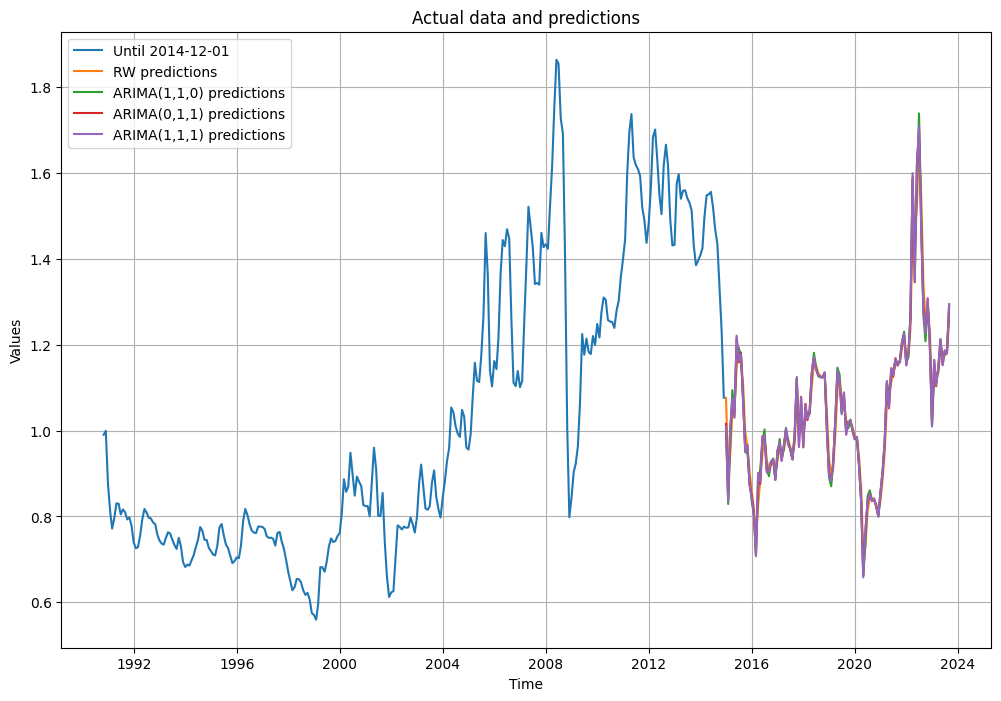

In [132]:
plt.figure(figsize=(12,8))
plt.plot(train['Time'], train['Real_Price'], label = 'Until 2014-12-01')
plt.plot(test['Time'], exp_rw_forecasts, label = 'RW predictions')
plt.plot(test['Time'], exp_arima_110_forecasts, label = 'ARIMA(1,1,0) predictions')
plt.plot(test['Time'], exp_arima_011_forecasts, label = 'ARIMA(0,1,1) predictions')
plt.plot(test['Time'], exp_arima_111_forecasts, label = 'ARIMA(1,1,1) predictions')

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual data and predictions')
plt.grid()
plt.legend()
plt.show()

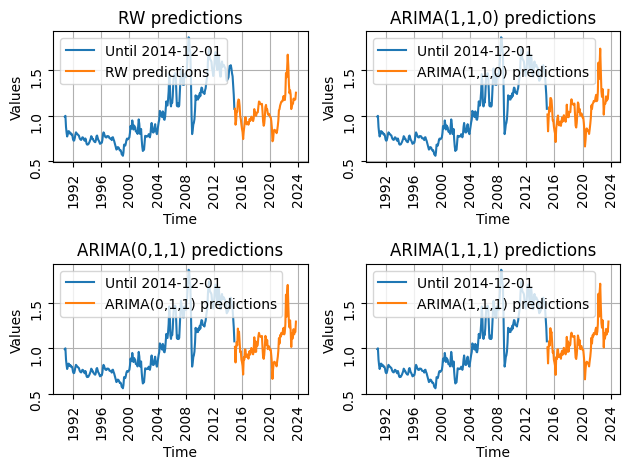

In [133]:
fig, ax = (plt.subplots(nrows=2, ncols=2))

ax[0,0].plot(train['Time'], train['Real_Price'], label = 'Until 2014-12-01')
ax[0,0].plot(test['Time'], exp_rw_forecasts, label = 'RW predictions')
ax[0,0].set_title('RW predictions')

ax[0,1].plot(train['Time'], train['Real_Price'], label = 'Until 2014-12-01')
ax[0,1].plot(test['Time'], exp_arima_110_forecasts, label = 'ARIMA(1,1,0) predictions')
ax[0,1].set_title('ARIMA(1,1,0) predictions')

ax[1,0].plot(train['Time'], train['Real_Price'], label = 'Until 2014-12-01')
ax[1,0].plot(test['Time'], exp_arima_011_forecasts, label = 'ARIMA(0,1,1) predictions')
ax[1,0].set_title('ARIMA(0,1,1) predictions')

ax[1,1].plot(train['Time'], train['Real_Price'], label = 'Until 2014-12-01')
ax[1,1].plot(test['Time'], exp_arima_111_forecasts, label = 'ARIMA(1,1,1) predictions')
ax[1,1].set_title('ARIMA(1,1,1) predictions')

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel('Time')
        ax[i, j].set_ylabel('Values')
        ax[i, j].grid()
        ax[i, j].legend()
        ax[i,j].tick_params(labelrotation=90)

plt.tight_layout()
plt.show()

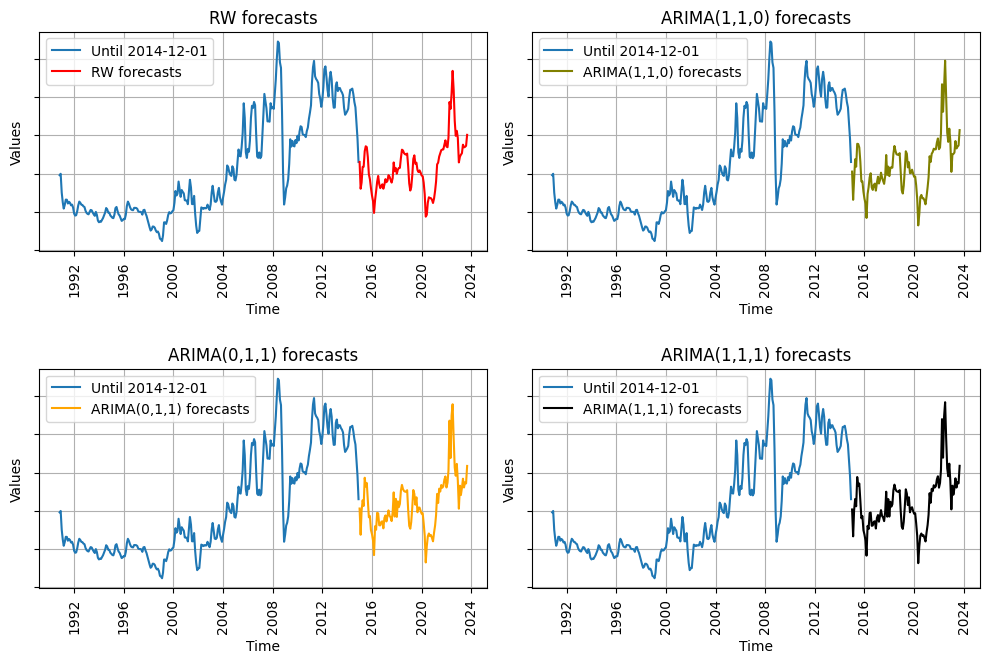

In [136]:
fig, ax = plt.subplots(nrows=2, ncols=2,
                       figsize=(10,6))

ax[0,0].plot(train['Time'], train['Real_Price'], label = 'Until 2014-12-01')
ax[0,0].plot(test['Time'], exp_rw_forecasts, label = 'RW forecasts', color='red')
ax[0,0].set_title('RW forecasts')

ax[0,1].plot(train['Time'], train['Real_Price'], label = 'Until 2014-12-01')
ax[0,1].plot(test['Time'], exp_arima_110_forecasts, label = 'ARIMA(1,1,0) forecasts', color='olive')
ax[0,1].set_title('ARIMA(1,1,0) forecasts')

ax[1,0].plot(train['Time'], train['Real_Price'], label = 'Until 2014-12-01')
ax[1,0].plot(test['Time'], exp_arima_011_forecasts, label = 'ARIMA(0,1,1) forecasts', color='orange')
ax[1,0].set_title('ARIMA(0,1,1) forecasts')

ax[1,1].plot(train['Time'], train['Real_Price'], label = 'Until 2014-12-01')
ax[1,1].plot(test['Time'], exp_arima_111_forecasts, label = 'ARIMA(1,1,1) forecasts', color='black')
ax[1,1].set_title('ARIMA(1,1,1) forecasts')

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel('Time')
        ax[i, j].set_ylabel('Values')
        ax[i, j].grid()
        ax[i, j].legend()
        ax[i,j].tick_params(labelrotation=90)
        ax[i,j].set_yticklabels([])

plt.tight_layout()
fig.subplots_adjust(bottom=0.01)
plt.show()

## 7) Compute the mean squared forecast error and comment

In [145]:
from sklearn.metrics import mean_squared_error

actual_values = test['Log_Real_Price']

rmse_rw_predictions = mean_squared_error(actual_values, exp_rw_forecasts, squared=False).round(4)
rmse_arima110_predictions = mean_squared_error(actual_values, exp_arima_110_forecasts, squared=False).round(4)
rmse_arima011_predictions = mean_squared_error(actual_values, exp_arima_011_forecasts, squared=False).round(4)
rmse_arima111_predictions = mean_squared_error(actual_values, exp_arima_111_forecasts, squared=False).round(4)

In [146]:
models = ['RW', 'ARIMA(1,1,0)', 'ARIMA(0,1,1)', 'ARIMA(1,1,1)']
rmse_values = [rmse_rw_predictions,
               rmse_arima110_predictions,
               rmse_arima011_predictions,
               rmse_arima111_predictions]

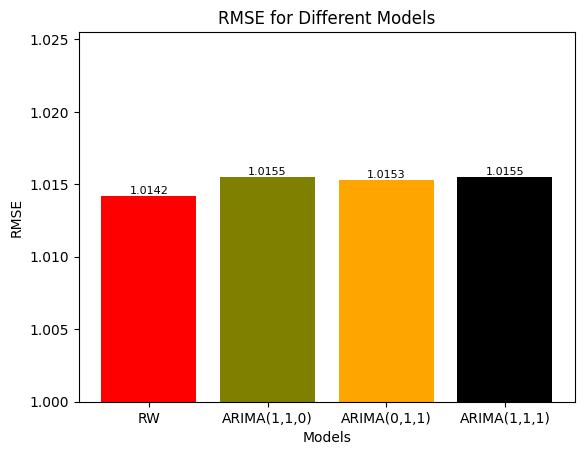

In [160]:
colors = ['red', 'olive', 'orange', 'black']

plt.bar(models, rmse_values, color = colors)

# Add data labels above each bar
for i, rmse in enumerate(rmse_values):
    plt.text(i, rmse, f'{rmse:.4f}', ha='center', va='bottom', fontsize=8)

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE for Different Models')
plt.ylim(1, max(rmse_values) + 0.01)


plt.show()